## PyTorch Introduction

Aufgabe:

* Trainieren Sie ein mehrschichtiges Neuronales Netz mit PyTorch.
* Zeigen Sie grafisch auf, dass Ihr Modell konvergiert.


#### Import & Settings

In [1]:
# in this code block we gather all imports

# PyTorch
import torch
import torch.nn as nn

# Data Splitting and Normalization is still often done using sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler

# numpy is just used in the beginning
import numpy as np

# for some plots and the scatter matrix
from matplotlib import pyplot as plt
#from matplotlib import colormaps as cm

# pandas for reading the CSV and for use with the library ppscore
import pandas as pd
#from pandas.api.types import CategoricalDtype

# ppscore for exploratory data analysis
#import ppscore as pps

# more statistics for exploratory data analysis
#from scipy import stats


In [2]:
# in this code block we determine the device to use depending on GPU availability

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('This Computation is running on {}.'.format(device))

This Computation is running on cpu.


#### Load Dataset

In [3]:
# in this code block we read the iris binary CSV file and perform some basic preprocessing

# read the CSV file
# using separator character semicolon
dataset_known_pd = pd.read_csv("../../data/iris_binary.csv", sep=',', skipinitialspace=True)

# make column names pythonic
# so that they can be used in code where applicable
dataset_known_pd.columns = dataset_known_pd.columns.str.replace(" ", "_")

# on a side note we choose to sort the data frame by the first column 
dataset_known_pd.sort_values(by='sepal_length', ascending=True, axis=0, inplace=True)

dataset_known_np = dataset_known_pd.to_numpy()

# number of target variables
n_targets = 1
print(f"n_targets={n_targets}")

# number of target classes
n_target_classes = 2
print(f"n_target_classes={n_target_classes}")

# number of instances
n_samples = dataset_known_np.shape[0]
print(f"n_samples={n_samples}")

# number of features
n_features = dataset_known_np.shape[1] - n_targets
print(f"n_features={n_features}")

assert dataset_known_pd.shape == (n_samples, n_features + n_targets)
assert dataset_known_np.shape == (n_samples, n_features + n_targets)

X_pd = dataset_known_pd.copy().drop('class', axis=1)
X_np = X_pd.to_numpy()
assert X_np.shape == (n_samples,n_features)

y_pd = dataset_known_pd['class'].copy()
y_np = y_pd.to_numpy()
assert y_np.shape == (n_samples,)

# we normalize all sample data which improves training efficiency quite a bit
# however with this particular iris binary dataset it would also work without normalization
scaler = StandardScaler()
X_norm_np = scaler.fit_transform(X_np)

X = torch.from_numpy(X_norm_np)
y = torch.from_numpy(y_np)

# we need the target data to be of data type float64 for the loss function to work
if y.dtype != torch.float64:
    y = y.double()
assert X.dtype == torch.float64
assert y.dtype == torch.float64

# also create a tensor that contains the 4 features and the target
y_unsqueezed = y.unsqueeze(1)
X_y = torch.cat((X, y_unsqueezed), 1)
assert X_y.shape == (n_samples, n_features + n_targets)
assert X_y.dtype == torch.float64


n_targets=1
n_target_classes=2
n_samples=150
n_features=4


In [4]:
dataset_known_pd

,sepal_length,sepal_width,petal_length,petal_width,class
22,4.3,3.0,1.1,0.1,0
128,4.4,2.9,1.4,0.2,0
141,4.4,3.0,1.3,0.2,0
3,4.4,3.2,1.3,0.2,0
47,4.5,2.3,1.3,0.3,0
...,...,...,...,...,...
119,7.7,3.0,6.1,2.3,1
13,7.7,3.8,6.7,2.2,1
44,7.7,2.6,6.9,2.3,1
56,7.7,2.8,6.7,2.0,1


In [5]:
# in this code block we split the dataset randomly into train and test data

# we first attempted to do this purely in PyTorch which is still a bit difficult
#dataset_known = torch.from_numpy(dataset_known_np)
#dataset_known_subsets = torch.utils.data.random_split(dataset_known, [int(n_samples * 0.7), int(n_samples * 0.3)])
#dataset_known_train_subset = dataset_known_subsets[0]
#dataset_known_test_subset = dataset_known_subsets[1]
#assert len(dataset_known_train_subset) == 105
#assert len(dataset_known_test_subset) == 45

# however many people still use pandas and sklearn which we follow for now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=77)

assert X_train.ndim == 2
assert X_test.ndim == 2
assert X_train.shape[0] + X_test.shape[0] == n_samples
assert X_train.shape[1] == n_features
assert X_test.shape[1] == n_features
assert X_train.dtype == torch.float64
assert X_test.dtype == torch.float64

assert (n_targets == 1 and y_train.ndim == 1) or (n_targets > 1 and y_train.ndim == 2)
assert y_train.dtype == torch.float64

assert (n_targets == 1 and y_test.ndim == 1) or (n_targets > 1 and y_test.ndim == 2)
assert y_test.dtype == torch.float64

assert y_train.shape[0] + y_test.shape[0] == n_samples


In [6]:
# in this code block we define a model

class ClassificationANNModel(nn.Module):
    def __init__(self,in_ndim,out_ndim):
        super(ClassificationANNModel,self).__init__()
        self.input_layer     = nn.Linear(in_ndim,32,dtype=torch.float64)
        self.hidden_layer_1  = nn.Linear(32,16,dtype=torch.float64)
        self.output_layer    = nn.Linear(16,out_ndim,dtype=torch.float64)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        out_1 = self.relu(self.input_layer(X))
        out_2 = self.relu(self.hidden_layer_1(out_1))
        out_3 = self.output_layer(out_2)
        return out_3


In [7]:
# in this code block we create a model

n_inputs = n_features
n_outputs = n_target_classes
if n_target_classes == 2:
    # for binary classification we use just 1 neuron in the output layer 
    n_outputs = 1

model = ClassificationANNModel(n_inputs, n_outputs).to(device)


In [8]:
# in this code block we chose loss function and an optimizer

#loss = nn.BCELoss()
loss = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.003)


In [9]:
# in this code block we define a our function to get from the raw model output to classes

# note that alternatively we could decide to put some or all of this into layers in the model

def logits_to_probabilities_to_classes(y_logits):
    #print(f"y_logits.shape={y_logits.shape}")
    assert y_logits.dtype == torch.float64
    #print(y_logits[0])

    # apply the logistic function to the model output to obtain values between 0 and 1
    # considered something like a probability how likely it is that the sample falls into the class
    y_after_sigmoid = torch.sigmoid(y_logits)
    #print(f"y_after_sigmoid.shape={y_after_sigmoid.shape}")
    assert y_after_sigmoid.dtype == torch.float64
    assert y_after_sigmoid.shape == y_logits.shape
    #print(y_after_sigmoid[0])

    # round the values to obtain the class values
    y_rounded = torch.round(y_after_sigmoid)
    #print(f"y_rounded.shape={y_rounded.shape}")
    assert y_rounded.dtype == torch.float64
    assert y_rounded.shape == y_logits.shape
    #print(y_rounded[0])

    # obtain the vector of class values
    # we assume that the first column is now
    # value 1.0 if the sample is predicted to be in class 1
    # value 0.0 if the sample is predicted to be in class 0
    #y_classes = y_rounded[:,0]#.long()
    y_classes = y_rounded[:, 0]#.long()
    #print(f"y_classes.shape={y_classes.shape}")
    assert y_classes.dtype == torch.float64
    assert y_classes.ndim == 1
    #print(y_classes[0])

    return  y_classes 
  

In [10]:
# in this code block we define a function for measuring prediction accuracy

def binary_acc(y_pred_classes_train, y_pred_classes_test):
    correct_results_sum = (y_pred_classes_train == y_pred_classes_test).sum().float()
    acc = correct_results_sum / y_pred_classes_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc


In [11]:
# in this code block we define the training process

# ls_train is a tensor to store the loss values w.r.t. training data after each epoch
# ls_test is a tensor to store the loss values w.r.t test data after each epoch
# debug can be set to True to print information during every 10th epoch
def train_model(n_epochs,model,optimizer,loss,X_train,y_train,ls_train,accs_train,X_test,y_test,ls_test,accs_test,debug):
    assert X_train.dtype == torch.float64
    assert y_train.dtype == torch.float64
    assert X_test.dtype == torch.float64
    assert y_test.dtype == torch.float64

    print("Training starts.")
    print(f"n_epochs={n_epochs}")

    # this code section is only needed if the model would have 2 output neurons instead of 1
    # if the model has 2 output neurons we need to transform y_train so that it has two columns
    # i.e. its original column and another columns with the same values however inverted
    # an alternative would be to drop the second column from y_pred_logits_train
    #y_train_inverted = (y_train * -1) + 1
    #y_train_shaped = torch.cat((y_train.unsqueeze(1), y_train_inverted.unsqueeze(1)), 1)

    # this code section is only needed if the model would have 2 output neurons instead of 1
    # if the model has 2 output neurons we need to transform y_test so that it has two columns
    # i.e. its original column and another columns with the same values however inverted
    # an alternative would be to drop the second column from y_pred_logits_test
    #y_test_inverted = (y_test * -1) + 1
    #y_test_shaped = torch.cat((y_test.unsqueeze(1), y_test_inverted.unsqueeze(1)), 1)

    # loop through the epochs one after the other
    for epoch in range(n_epochs):
        # clear gradients from a previous epoch
        optimizer.zero_grad()
        
        # ensure model is in training mode
        model.train()
        
        y_pred_logits_train = model(X_train)

        # predict with respect to the whole training dataset
        y_pred_classes_train = logits_to_probabilities_to_classes(y_pred_logits_train)
        
        # immediately compute current accuracy with respect to the training data
        accs_train[epoch] = binary_acc(y_pred_classes_train, y_train).item()

        # compute training loss
        # note that we pass the logits to the loss function since we use BCEWithLogitsLoss
        l_train = loss(y_pred_logits_train, y_train.unsqueeze(1))

        # backward propagation to compute gradients
        l_train.backward()

        # now update weights
        optimizer.step()

        ls_train[epoch] = l_train.item()

        model.eval()
        with torch.inference_mode():
            assert X_train.shape != X_test.shape
            # perform a test to see how good the model is now
            y_pred_logits_test = model(X_test)
            assert y_pred_logits_train.shape != y_pred_logits_test.shape
            y_pred_classes_test = logits_to_probabilities_to_classes(y_pred_logits_test)
            # compute test accuracy
            accs_test[epoch] = binary_acc(y_pred_classes_test, y_test).item()
            # compute test loss
            # note that we pass the logits to the loss function since we use BCEWithLogitsLoss
            l_test = loss(y_pred_logits_test, y_test.unsqueeze(1))
            ls_test[epoch] = l_test.item()

        if debug and ((epoch <= 500 and epoch % 20 == 0) or (epoch > 500 and epoch % 500 == 0)):
            print(f"epoch                  {epoch}")
            print(f"accs_train[epoch]      {accs_train[epoch]}")
            print(f"accs_test[epoch]       {accs_test[epoch]}")
            print(f"ls_train[epoch]        {ls_train[epoch]}")
            print(f"ls_test[epoch]         {ls_test[epoch]}")
            print(f"----------------------------------------------------------------")

    print(f"Training ends.")



In [12]:
# in this code block we perform a training of the model

n_epochs = 5000

debug = True

# note that we already put the model to the device before and now we put the data to the device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

ls_train = torch.from_numpy(np.zeros(n_epochs, dtype='float64'))
ls_train = ls_train.to(device)
accs_train  = torch.from_numpy(np.zeros(n_epochs, dtype='float64'))
accs_train.to(device)

ls_test  = torch.from_numpy(np.zeros(n_epochs, dtype='float64'))
ls_test = ls_train.to(device)
accs_test  = torch.from_numpy(np.zeros(n_epochs, dtype='float64'))
accs_test.to(device)

train_model(n_epochs, model, optimizer, loss, X_train, y_train, ls_train, accs_train, X_test, y_test, ls_test, accs_test, debug)


Training starts.
n_epochs=5000
epoch                  0
accs_train[epoch]      67.0
accs_test[epoch]       67.0
ls_train[epoch]        0.6993184166288658
ls_test[epoch]         0.6993184166288658
----------------------------------------------------------------
epoch                  20
accs_train[epoch]      67.0
accs_test[epoch]       67.0
ls_train[epoch]        0.691737384869798
ls_test[epoch]         0.691737384869798
----------------------------------------------------------------
epoch                  40
accs_train[epoch]      67.0
accs_test[epoch]       67.0
ls_train[epoch]        0.6843371218744733
ls_test[epoch]         0.6843371218744733
----------------------------------------------------------------
epoch                  60
accs_train[epoch]      67.0
accs_test[epoch]       67.0
ls_train[epoch]        0.6770296766195976
ls_test[epoch]         0.6770296766195976
----------------------------------------------------------------
epoch                  80
accs_train[epoch]     

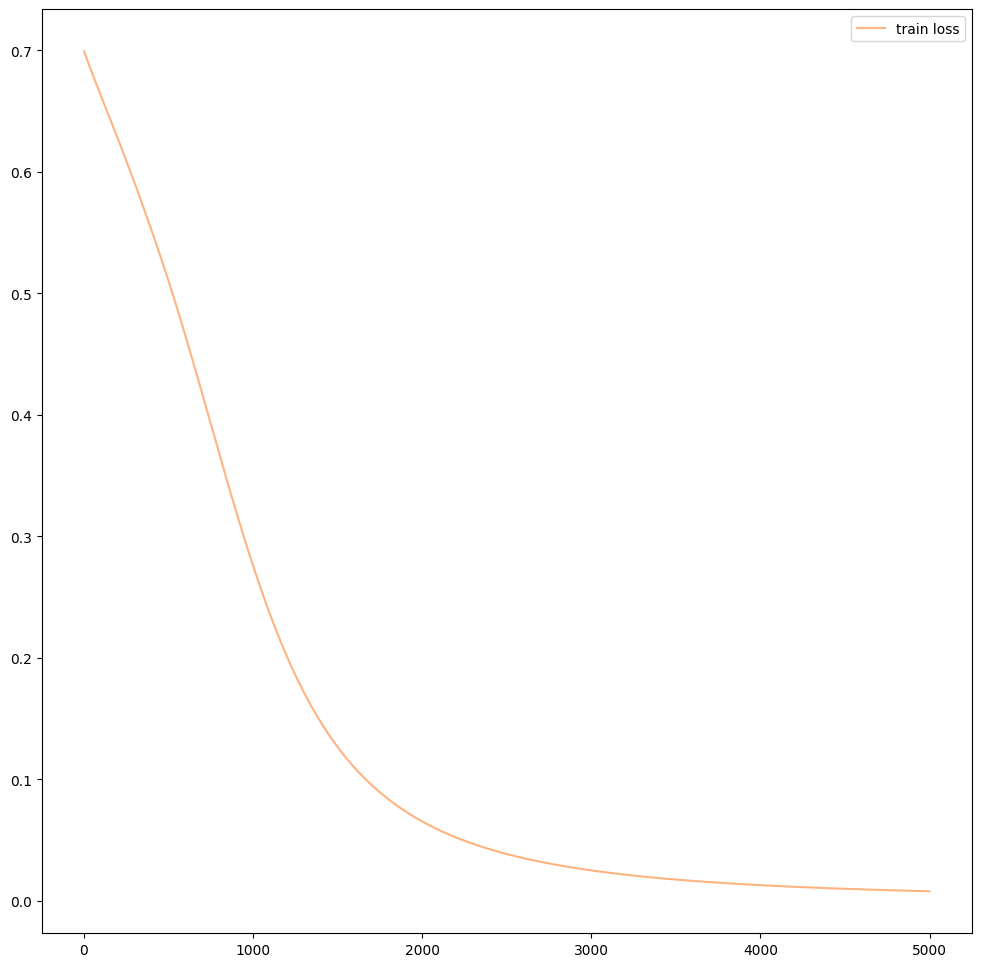

In [13]:
# in this code block we visualize the training loss

plt.figure(figsize=(12,12),dpi=100)
plt.plot(ls_train, label='train loss', color='#ffb380')
plt.legend()
plt.show()


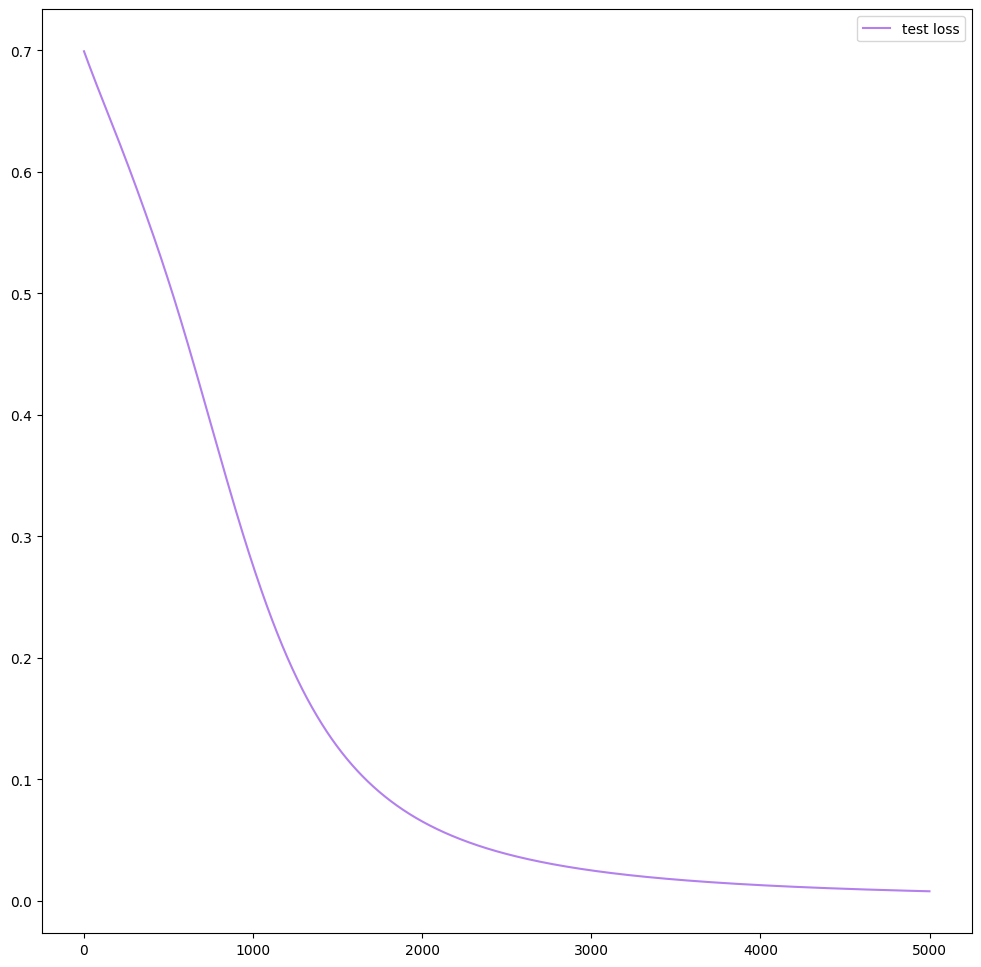

In [14]:
# in this code block we visualize the test loss

plt.figure(figsize=(12,12),dpi=100)
plt.plot(ls_test, label='test loss', color='#b380ee')
plt.legend()
plt.show()


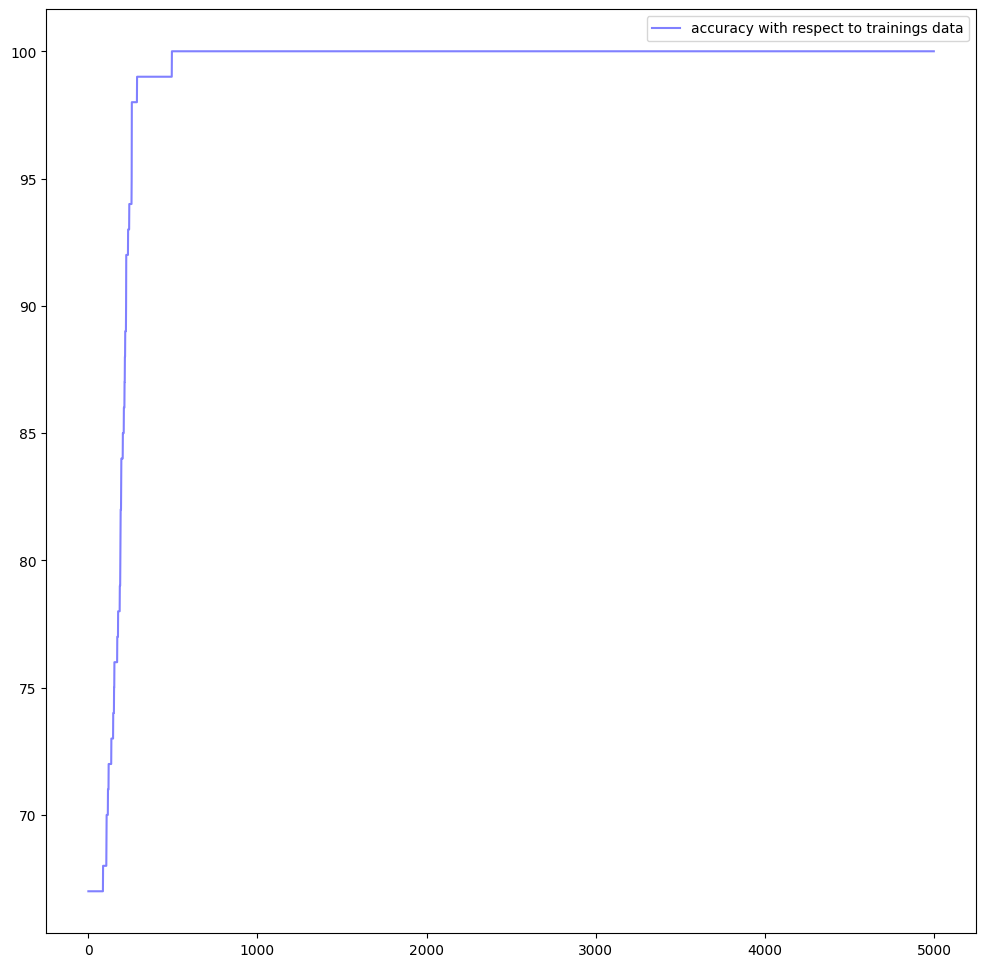

In [15]:
# in this code block we visualize the accuracy with respect to trainings data

plt.figure(figsize=(12,12),dpi=100)
plt.plot(accs_train, label='accuracy with respect to trainings data', color='#8080ff')
plt.legend()
plt.show()

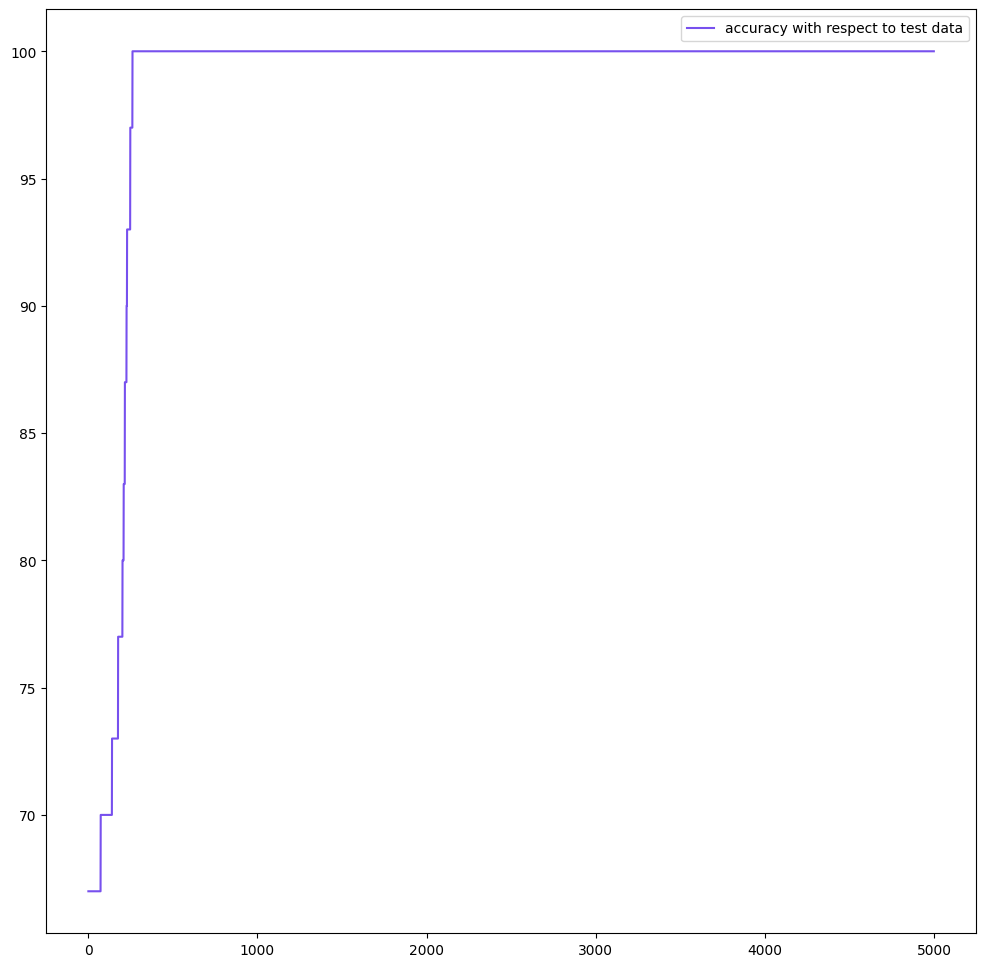

In [16]:
# in this code block we visualize the accuracy with respect to test data

plt.figure(figsize=(12,12),dpi=100)
plt.plot(accs_test, label='accuracy with respect to test data', color='#7750ee')
plt.legend()
plt.show()

In [17]:
# in this code block we have the model perform inference on all of the data

model.eval()
with torch.inference_mode():
    # perform a test to see how good the model is now

    # actual
    y_pred_logits_all = model(X)
    y_pred_classes_all = logits_to_probabilities_to_classes(y_pred_logits_all)
    y_pred_classes_all_int64 = y_pred_classes_all.long()

    # expected
    y_pred_perceptron_np = np.asarray([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], dtype='int64')
    y_pred_preceptron = torch.from_numpy(y_pred_perceptron_np)

    # assertion that all predictions were correct
    assert (y_pred_classes_all_int64 == y_pred_preceptron).all()

    print(y_pred_classes_all_int64)


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
